# Notebook for visualizing trajectory analysis of the Tumor - Epithelium subset

###### https://www.biorxiv.org/content/10.1101/2023.06.21.545980v1

## Import Jobs

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scvelo as scv
import cellrank as cr
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hc
import matplotlib.patches as patches
import plotly.express as px

import matplotlib as mpl
import matplotlib
from matplotlib import rcParams
from adjustText import adjust_text
from scipy.stats import zscore
from copy import deepcopy
from kneed.knee_locator import KneeLocator
from sklearn.metrics.cluster import adjusted_rand_score
from py_pcha.PCHA import PCHA
from skimage import filters
from scipy import stats
from pprint import pprint
from collections import Iterable, defaultdict

import palantir
import scipy
import sys
import os
import glob
import anndata
import itertools
import phenograph
import sklearn
import scanorama
import scikit_posthocs
import slepc4py
import petsc4py
import fastcluster

from os import path
from pathlib import Path
from scipy.ndimage.filters import convolve

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


In [2]:
# Define output directory:

output_dir = '/workdir/varmus_single_cell/merged_pipeline_out/TEC_out_PubShare/'
!mkdir -p {output_dir}
print(f'output_dir: {output_dir}')
run_in_background_wait_default=True

output_dir: /workdir/varmus_single_cell/merged_pipeline_out/TEC_out_PubShare/


In [3]:
# Format notebook style:

boolean_to_color = {True:'crimson',False:'steelblue'}

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.output_result { max-width:85% !important; }</style>"))

In [4]:
# Define default parameters

%matplotlib inline

sc.settings.figdir = output_dir

sc.set_figure_params(dpi=80, dpi_save=400)

matplotlib.style.use('default')
scv.settings.set_figure_params('scanpy')
sns.set_style('white')

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
scv.settings.figdir = output_dir

cr.settings.verbosity = 2
cr.settings.figdir = output_dir

In [5]:
plt.rcParams['figure.figsize']=(6,4) #rescale figures
sc.settings.verbosity = 4

In [6]:
# Define helper functions:

def flatten(l):
    if all(isinstance(x, list) for x in l):
        return [item for sublist in l for item in sublist]
    elif all(isinstance(x, np.ndarray) for x in l):
        return [item for sublist in l for item in sublist]
    else:
        return 'Input List is Not Nested'
    
    
# run bash command in background if stdoutfile does not exist. If it does, output contents of stdoutfile.
# If force=true, overwrite and re-run command.
def run_in_background(command, stdoutfile, stderrfile="", force=False, quiet=False, 
                      wait=run_in_background_wait_default):
    if force or not path.exists(stdoutfile):
        command = 'bash -c \'' + command + '\' > ' + stdoutfile
        if stderrfile:
            command = command + ' 2>' + stderrfile
        else:
            command = command + ' 2>&1'
        if not wait:
            command = command + ' &'
        print('calling ' + command + '\n')
        os.system(command)
    else:
        wait=True
    if wait:
        if not quiet:
            print("Output from stdout file " + stdoutfile)
            !cat {stdoutfile}
        else:
            print("Output from stdout file " + stdoutfile + " is suppressed")
        if stderrfile and path.exists(stderrfile):
            print("Output from stderr file " + stderrfile)
            !cat {stderrfile}
            
            
def filter_genes(adata, minCell):
    hasCell = adata.layers['X'] > 0
    numCell = np.array(hasCell.sum(axis=0))
    tooSmall = [i < minCell for i in numCell]
    is_invalid = np.zeros(adata.shape[1], np.bool)
    is_invalid[np.where(tooSmall)[0]] = True
    print(f"Removing {np.sum(is_invalid)} out of {len(is_invalid)} genes with less than {minCell} cells")
    adata.var['n_cells_by_counts'] = numCell
    return is_invalid



def read_mast_results(xls, sheetname, filter_genes=None, filter_label='_filtered', reverse=False,
                      sortBy='scaled_rank_score'):
    print("Reading " + sheetname)
    mastResults = pd.read_excel(xls, sheetname)
    mastResults.rename(index=str, columns={"primerid": "gene", "coef": "log2FC", 'Pr(>Chisq)':'p',
                                          'Pr..Chisq.':'p'}, inplace=True, errors='ignore')
    pmin= np.min(np.array([x for x in mastResults.p if x!=0]))
    fdrmin = np.min(np.array([x for x in mastResults.fdr if x!=0]))
    #mastResults.log2FC[np.isnan(mastResults.log2FC)] = np.nanmax(mastResults.log2FC)
    mastResults = mastResults[(np.isnan(mastResults['ci.lo']) == False) & (np.isnan(mastResults['ci.hi']) == False)]
    mastResults.drop(['Unnamed: 0'], axis=1, inplace=True)
    mastResults.set_index('gene', drop=True, inplace=True)
    mastResults['bonferroni'] = mastResults['p']*mastResults.shape[0]
    bonmin = np.min(np.array([x for x in mastResults.bonferroni if x!=0]))
    mastResults.loc[mastResults.p==0,'p'] = pmin
    mastResults.loc[mastResults.fdr==0,'fdr'] = fdrmin
    mastResults.loc[mastResults.bonferroni==0,'bonferroni'] = bonmin
    mastResults.loc[mastResults.bonferroni > 1,'bonferroni'] = 1
    mastResults['rank_score'] = -10*np.log10(mastResults['bonferroni'])*np.sign(mastResults['log2FC'])
    mastResults['FC'] = 2.0**mastResults['log2FC']
    mastResults['scaled_rank_score'] = mastResults['rank_score']*np.abs(mastResults['log2FC'])
    mastResults['abs_scaled_rank_score'] = np.abs(mastResults['scaled_rank_score'])
    if reverse:
        mastResults['log2FC'] = -mastResults['log2FC']
        mastResults['FC'] = 1.0/mastResults['FC']
        mastResults['ci.hi'] = -mastResults['ci.hi']
        mastResults['ci.lo'] = -mastResults['ci.lo']
        mastResults['rank_score'] = -mastResults['rank_score']
        mastResults['scaled_rank_score'] = -mastResults['scaled_rank_score']
    mastResults = mastResults.sort_values(by=sortBy, ascending=False)
    if filter_genes is not None:
        mastResults = mastResults.loc[[g for g in mastResults.index if g in filter_genes]]
        filename=os.path.splitext(sheetname)[0] + filter_label + '.csv'
        mastResults[['p', 'log2FC', 'FC', 'fdr', 'ci.hi','ci.lo','bonferroni','rank_score', 'scaled_rank_score']].to_csv(filename)
    return(mastResults)


def make_volcano_plot(df, title='MAST volcano plot', plot_outfile = None, 
                      ptype='bonferroni', mlog10_thresh=-np.log10(0.1), log2FC_thresh = np.log2(1.1),
                      num_label=15, arrows=True, 
                      fontsize=17,
                      figsize=(12,10),
                      axis_lines=False,
                      xlabel_cutoff=0.1,
                      minY=-1,
                      ycol='fdr',
                      xcol='log2FC',
                      xlabel='$log_2(FC)$',
                      ylabel='$-log{10}(p_{adj})$',
                      labelcol='index', 
                      label_list=None,
                      color_var=None,
                      cmap=None,
                      s=5, 
                      color='r',
                      alpha=1):
    
    print("ptype:", ptype)
    print("ycol:", ycol)
    # Identify significant genes to highlightlabelle
    target_num_label = num_label
    num_label=500
    while num_label > target_num_label:
        f = ((df[ycol] < 0.05) & ((df[xcol] > xlabel_cutoff) | (df[xcol] < -xlabel_cutoff)) & (df[ptype] < 0.5))
        num_label = np.sum(f)
        if (num_label > target_num_label):
            xlabel_cutoff = xlabel_cutoff+0.01
    print(f"num_label={num_label}, xlabel_cutoff={xlabel_cutoff}")

    x = df[xcol].to_numpy()
    
    y = df[ptype].to_numpy()
    if (np.sum(y==0) > 0):
        y[y==0] = np.min(y[y!=0])/2
    y = -np.log10(abs(df[ptype].to_numpy()))*np.sign(df[ptype]).to_numpy()
    
    if label_list==None:
        sig_ind = np.where((np.abs(x) > log2FC_thresh) * (np.abs(y) > mlog10_thresh))[0]    
        f = sig_ind
        
    else:
        if labelcol=='index':
            sig_ind = np.array(df.index.map(lambda x: x in label_list)).astype(bool)
        else:
            sig_ind = np.array(df[labelcol].map(lambda x: x in label_list)).astype(bool)
        f = np.where((np.abs(x) > log2FC_thresh) * (np.abs(y) > mlog10_thresh))[0]  
        
    fig, ax = plt.subplots(figsize=figsize)
    
    # Make Volcano plot
    plt.scatter(x, y, s=s, c='k', alpha=alpha)
    
    if color_var == None:
        plt.scatter(x[sig_ind], y[sig_ind], s=10*s, c=color)
    else:
        if cmap == None:
            print('No cmap provided.')
        else:
            plt.scatter(x[sig_ind], y[sig_ind], s=10*s, c=[cmap[x] for x in df.iloc[sig_ind][color_var].values])
        
    plt.title(title, fontsize=14)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.xlabel(xlabel, size=14, weight='normal')
    plt.ylabel(ylabel, size=14, weight='normal')
    #maxX = np.nanmax(np.append(np.abs(x), 1.5))
    #maxY = np.nanmax(np.append(y, 350))
    maxX = np.nanmax(np.abs(x))
    maxY = np.nanmax(y)
    plt.xlim(-maxX-0.25, maxX+0.25)
    plt.ylim(-0.25, maxY*1.2)
    plt.grid(b=None)
    sns.despine()
    ax=plt.gca()
    ax.grid(False)
    
    #plt.axvline(0, linestyle='--', linewidth=1, color='grey')
    
    if axis_lines:
        plt.vlines(x=0, ymin=minY, ymax=maxY+100, linestyles='dashed', color='grey')
        plt.hlines(y=0, xmin=-maxX-1, xmax=maxX+1, linestyles='dashed', color='grey')
    
    #f = (df['fdr'] < 0.01) & ((df['log2FC'] > 0.2) | (df['log2FC'] < -0.2))
    if labelcol == 'index':
        z = sorted(zip(y[f], x[f], df.index[f]), reverse=True)
    else:
        z = sorted(zip(y[f], x[f], df[labelcol][f]), reverse=True)
        
    
    if label_list==None:
        if num_label > 0:
    #        z=sorted(zip(y,x,df.index), reverse=True)[:num_label]
            texts = []
            for i in range(len(z)):
                texts.append(ax.text(z[i][1], z[i][0], z[i][2], fontsize=fontsize))
            if (arrows):
                niter=adjust_text(texts, x=x, y=y, 
                                  #force_text=(0.5,0.5),
                                  #force_points=(0.5,0.5),
                                  #expand_text=(2,2),
                                  #expand_points=(2,2),
                                  #autoalign='x',
                                  precision=0.001,
                                  arrowprops=dict(arrowstyle='-|>', color='gray', lw=0.5))
            else:
                niter = adjust_text(texts, x=x, y=y, force_text=0.05)
            #print("niter=" + str(niter))
        
    else:
        z = [x for x in z if x[2] in label_list]
            
        #print(z)
        
        texts = []
        for i in range(len(z)):
            texts.append(ax.text(z[i][1], z[i][0], z[i][2], fontsize=fontsize))
        if (arrows):
            niter=adjust_text(texts, x=x, y=y, 
                              #force_text=(0.5,0.5),
                              #force_points=(0.5,0.5),
                              #expand_text=(2,2),
                              #expand_points=(2,2),
                              #autoalign='x',
                              precision=0.001,
                              arrowprops=dict(arrowstyle='-|>', color='gray', lw=0.5))
        else:
            niter = adjust_text(texts, x=x, y=y, force_text=0.05)

    
    # SAVE FIGURE
    if plot_outfile is not None:
        d = os.path.dirname(plot_outfile)
        if not os.path.exists(d):
            os.makedirs(d)
        plt.savefig(plot_outfile, bbox_inches='tight', dpi=400)
        print("Wrote " + plot_outfile)
    plt.show()

In [8]:
%pip freeze

adjustText==0.7.3
aiohttp==3.8.4
aiosignal==1.3.1
anndata==0.8.0
anndata2ri==1.0.6
annoy==1.17.0
appdirs==1.4.4
arboreto==0.1.6
argon2-cffi==20.1.0
asn1crypto==0.24.0
async-generator==1.10
async-timeout==4.0.2
asynctest==0.13.0
attrs==21.2.0
backcall==0.2.0
beautifulsoup4==4.9.3
biofluff==3.0.4
biopython==1.81
bioservices==1.7.11
biothings-client==0.3.0
bleach==3.3.0
bokeh==2.4.3
boltons==23.0.0
cached-property==1.5.2
cellrank==1.5.1
certifi==2018.1.18
cffi==1.14.5
chardet==3.0.4
charset-normalizer==3.1.0
click==8.0.1
cloudpickle==2.2.1
cmake==3.18.2
cmocean==2.0
colorama==0.4.4
colorlog==5.0.1
compress-json==1.0.8
configparser==5.3.0
cryptography==2.1.4
ctxcore==0.2.0
cycler==0.10.0
Cython==0.29.23
cytoolz==0.12.1
dask==2022.2.0
dateparser==1.1.8
decorator==4.4.2
defusedxml==0.7.1
dill==0.3.4
diskcache==5.6.3
distributed==2022.2.0
distro-info===0.18ubuntu0.18.04.1
docrep==0.3.2
doubletdetection==3.0
easydev==0.11.1
entrypoints==0.3
environments-utils==1.0.10
et-xmlfile==1.1.0
fa2==0.3

## Import Value Maps

In [ ]:
# Import mouse to human mapping dictionary from GitHub:

import pickle 

with open('/workdir/varmus_single_cell/code/github_notebooks/mToH_mapping.pkl', 'rb') as f:
    mToH_mapping = pickle.load(f)

In [ ]:
cell_type_cmap = {'Tumor cells': '#A4D10A', 
                  'AT1': '#E37979', 
                  'AT2': '#C70B0B', 
                  'LUAD': '#A3523B',
                  'B cells': '#F9D318', 
                  'Basal cells': '#7FD5A6', 
                  'Chondrocytes': '#79A274',
                  'Club cells': '#D36C39', 
                  'Transitional Club-AT2': '#C64A18',
                  'EC arterial': '#6B0C0C', 
                  'EC aerocyte': '#8D6868',
                  'EC general capillary': '#BF5B5B', 
                  'EC venous': '#782C2C', 
                  'Lymphatic EC': '#BD872F',
                  'Ciliated cells': '#D39939', 
                  'cDC1': '#C438FB',
                  'cDC2': '#E9B1FF',
                  'Migratory DCs': '#962A6F',
                  'DCs': '#C438FB',
                  'Endothelial cells': '#6B0C0C',
                  'Stromal cells': '#9BA65A', 
                  'Ionocyte': '#3C787D',
                  'Tuft': '#66966C',
                  'Secretory cells': '#B0A170',
                  'Submucosal cells': '#A4B070',
                  'Pericytes': '#046C50',
                  'Myofibroblasts': '#C15376',
                  'Smooth muscle': '#946E6E',
                  'Mesothelium': '#E16666',
                  'Fibroblast cells': '#216C04', 
                  'Alveolar macrophages': '#7AD9DA',
                  'Interstitial Macrophages': '#7AAEDA',
                  'Macrophages/mMDSC': '#7AC0DA',
                  'Monocytes': '#51ECAE', 
                  'Monocytic cells': '#51ECAE',
                  'Mast cells': '#A16E0F', 
                  'Multiciliated cells': '#F17C62',
                  'NK cells': '#EA0C0C', 
                  'Granulocytic cells': '#9CA7A8', 
                  'T cells': '#F47D08', 
                  'Plasma cells': '#90F162',
                  'Mature B cells/Plasma cells': '#90F162',
                  'pDC': '#51119A',
                  'PNEC': '#0B11C7',
                  'Tumor AT2': '#A3523B',
                  'Tumor PNEC': '#3B3587',
                  'Tumor cells': '#8A7B7B',
                  'unassigned': '#DEDEDE'}

cell_type_name_map = {'Tumor cells': 'Tumor cells', 
                      'AT1': 'AT1', 
                      'AT2': 'AT2', 
                      'B cells': 'B cells', 
                      'Basal Cells': 'Basal cells', 
                      'Chondrocyte': 'Chondrocytes',
                      'Club cell': 'Club cells', 
                      'Transitional Club AT2': 'Transitional Club-AT2',
                      'EC arterial': 'EC arterial', 
                      'EC aerocyte capillary': 'EC aerocyte',
                      'EC general capillary': 'EC general capillary', 
                      'EC venous': 'EC venous', 
                      'Lymphatic EC': 'Lymphatic EC',
                      'Ciliated cell': 'Ciliated cells', 
                      'DC1': 'cDC1',
                      'DC2': 'cDC2',
                      'Migratory DCs': 'Migratory DCs',
                      'DCs': 'DCs',
                      'Endothelial cell': 'Endothelial cells',
                      'Stromal Cell': 'Stromal cells', 
                      'Ionocyte': 'Ionocyte',
                      'Tuft': 'Tuft',
                      'Secretory Cells': 'Secretory cells',
                      'Submucosal': 'Submucosal cells',
                      'Pericytes': 'Pericytes',
                      'Myofibroblasts': 'Myofibroblasts',
                      'Smooth muscle': 'Smooth muscle',
                      'Mesothelium': 'Mesothelium',
                      'Fibroblasts': 'Fibroblast cells', 
                      'Alveolar macrophages': 'Alveolar macrophages',
                      'Interstitial Macrophages': 'Interstitial Macrophages',
                      'Macrophage': 'Macrophages/mMDSC',
                      'Macrophages': 'Macrophages/mMDSC',
                      'Monocytes': 'Monocytes', 
                      'Mast cells': 'Mast cells', 
                      'Multiciliated Cells': 'Multiciliated cells',
                      'NK cells': 'NK cells', 
                      'Granulocytic': 'Granulocytic cells', 
                      'T cells': 'T cells', 
                      'Plasma cells': 'Plasma cells',
                      'pDCs': 'pDC',
                      'PNEC': 'PNEC',
                      'unassigned': 'unassigned'}

## Import Data

In [13]:
# Read in published HT subset
# or results from HT Trajectory Computation Notebook:

fn = '/workdir/varmus_single_cell/data/NOBACKUP/Gardner_et_al_GEO_Upload_2023/Gardner_et_al_RNAseq_GEO_Upload/'+\
     'Gardner_et-al-2023_processed_adata_histological_transformation_subset.h5ad'

adata_FULL = sc.read(fn)
adata_HVG = adata_FULL[:,adata_FULL.var.highly_variable == True]

In [ ]:
adata_FULL

In [ ]:
adata_HVG.shape

In [ ]:
adata_FULL.shape

### FDL Projections

In [ ]:
adata_HVG.obs['sample'].unique()

In [ ]:
# Define sample color map:

sample_cmap = {'AT2_1mo': '#AD0404', 
               'ERPMT_pool': '#ff0000', 
               'ERPMT_doxMRD': '#E896D1', 
               'ERPMT_3moMRD': '#9012F1', 
               'transformed_SCLC': '#46A8FF', 
               'RPMT_pool': '#0432ff',
               'ERPMT_MRDrestart': '#d2b14c'}

adata_FULL.uns['sample_colors'] = [sample_cmap[x] for x in sorted(adata_FULL.obs['sample'].unique())]
adata_HVG.uns['sample_colors'] = [sample_cmap[x] for x in sorted(adata_HVG.obs['sample'].unique())]

In [ ]:
sc.settings.figdir

In [ ]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.draw_graph(adata_HVG, 
                 color='sample', 
                 s=10,
                 alpha=0.5,
                 add_outline=True,
                 save='_sample_FDR.png')

In [ ]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 


sc.pl.draw_graph(adata_HVG, 
                 color='terminal_states_probs', 
                 s=10,
                 alpha=1,
                 cmap='viridis',
                 add_outline=True,
                 save='_terminal_states_probs_FDL.png')

In [ ]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 


sc.pl.draw_graph(adata_HVG, 
                 color='ERPMT_doxMRD_macrostate_probs', 
                 s=10,
                 alpha=0.1,
                 cmap='viridis',
                 add_outline=True)

In [ ]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

for g in ['ERPMT_pool_macrostate_probs', 'ERPMT_doxMRD_macrostate_probs', 'transformed_SCLC_macrostate_probs', 'AT2_1mo_macrostate_probs']:
    
    sc.pl.draw_graph(adata_HVG, 
                     color=g, 
                     s=10,
                     alpha=1,
                     cmap='viridis',
                     add_outline=True,
                     save=f'_{g}_probs_FDL.png')

In [ ]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

for macrostate in ['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'transformed_SCLC']:

    sc.pl.draw_graph(adata_HVG, 
                     color=f'{macrostate}_macrostate_probs', 
                     s=10,
                     alpha=1,
                     cmap='Greys',
                     vmin=0,
                     vmax=1,
                     add_outline=True,
                     save=f'_{macrostate}_probs_greyscale_FDL.png')

In [ ]:
scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
scv.set_figure_params(dpi=80, dpi_save=300) 

scv.pl.velocity_embedding_stream(adata_HVG, 
                                 vkey="T_fwd", 
                                 basis="draw_graph_fa", 
                                 color='sample', 
                                 s=10,
                                 alpha=0.5,
                                 add_outline=True,
                                 legend_loc="right",)

#### With RPMT in background

In [ ]:
fn

In [8]:
# Read in the full TEC subset:

fn = '/workdir/varmus_single_cell/data/NOBACKUP/Gardner_et_al_GEO_Upload_2023/Gardner_et_al_RNAseq_GEO_Upload/' +\
     'Gardner_et-al-2023_processed_adata_TEC_merged_new_samples.h5ad'

adata_TEC = sc.read(fn)

###### Import cell type assignments from GitHub 

In [21]:
fn = '/workdir/varmus_single_cell/code/github_notebooks/Macro_Cell_Type_Annotations.csv'

cellType_map = pd.read_csv(fn, index_col=0)

cellType_map = cellType_map.to_dict()['Macro Cell Type']

adata_TEC.obs['Macro Cell Type'] = adata_TEC.obs.index.map(cellType_map)

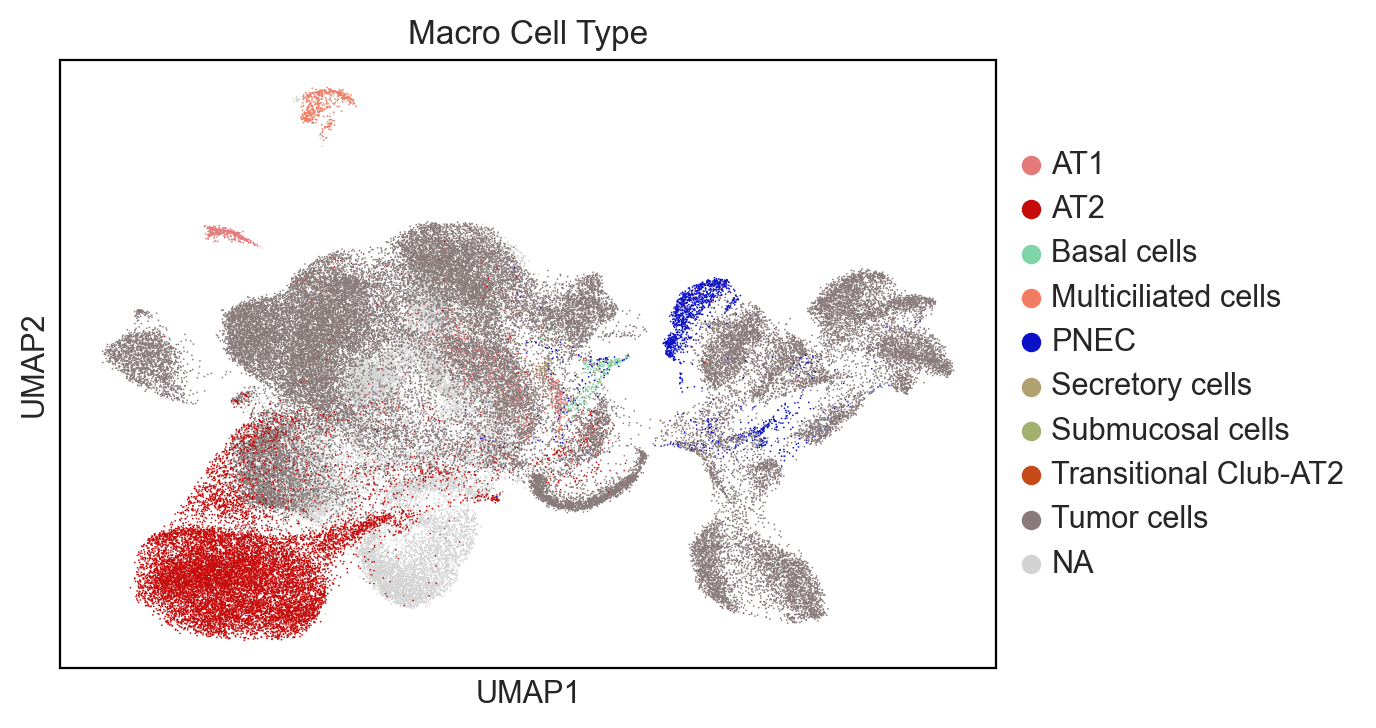

In [29]:
sc.pl.umap(adata_TEC, color='Macro Cell Type')

In [ ]:
adata_TEC

In [ ]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

# Using original FDL:
adata_TEC.obsm['X_merged_draw_graph_fa'] = adata_TEC.obsm['X_draw_graph_fa']
adata_TEC.obsm['X_draw_graph_fa'] = adata_TEC.obsm['X_OG_draw_graph_fa']

sc.pl.draw_graph(adata_TEC, color='sample')

In [ ]:
# Select samples of interest to view as a reference
# The published main figure used RPMT_pool
# One supplemental figure also used ERPMT_pool

sample_list_RPMT = adata_HVG.obs['sample'].unique().tolist() + ['RPMT_pool']

adata_TEC = adata_TEC[np.array(adata_TEC.obs['sample'].map(lambda x: x in sample_list_RPMT)).astype(bool)]

In [ ]:
# remove multiciliated:

adata_TEC = adata_TEC[adata_TEC.obs['Macro Cell Type'] != 'Multiciliated cells']

In [ ]:
adata_TEC.obs['Macro Cell Type'].value_counts()

In [ ]:
adata_TEC.uns['sample_colors'] = [sample_cmap[x] for x in sorted(adata_TEC.obs['sample'].unique())]

In [ ]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.draw_graph(adata_TEC, color='sample', alpha=[0 if x not in ['RPMT_pool']
                                                   else 1 for x in adata_TEC.obs['sample']], 
                 save='_TEC_FDL_RPMT_pool_ONLY.png')

In [ ]:
sc.settings.figdir

In [ ]:
# View all samples at full opacity:

sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

ax = sc.pl.draw_graph(adata_TEC,
                      color='sample', 
                      s=10,
                      add_outline=True,
                      outline_width=(0.4, 0.1),
                      outline_color=('black', 'white'),
                      #alpha=[0 if x != 'RPMT_pool' else 0.75 for x in adata_TEC.obs['sample']], 
                      alpha=0.75,
                      show=False)

In [ ]:
# This code generates the projection for RPMT and the HT samples separately on the same axis scale
# The two figures line up, and the RPMT projection is saved with lower alpha for the published figure

# RPMT Pool Only

ax1 = sc.pl.draw_graph(adata_TEC[np.array(adata_TEC.obs['sample'].map(lambda x: x in ['RPMT_pool'])).astype(bool)], 
                       color='sample', 
                       s=10,
                       add_outline=True,
                       outline_width=(0.4, 0.1),
                       outline_color=('black', 'white'),
                       #alpha=[0 if x != 'RPMT_pool' else 0.75 for x in adata_TEC.obs['sample']], 
                       alpha=0.75, # changing alpha here doesn't make hte projection consistently transparent b/c of density 
                       #ax=ax1,
                       #save='_TEC_FDL_RPMT_pool_ONLY_V2.png',
                       show=False)

ax1.set_xbound(lower=ax.get_xbound()[0], upper=ax.get_xbound()[1])
ax1.set_ybound(lower=ax.get_ybound()[0], upper=ax.get_ybound()[1])

ax1.set_xlim(ax.get_xlim())
ax1.set_ylim(ax.get_ylim())

fn = output_dir + f'/draw_graph_TEC_FDL_RPMT_pool_ONLY_V2.png'

print(fn)
plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True, frameon=True)


#################################################################################################
#################################################################################################
#################################################################################################


# Trajectory Samples Only

ax2 = sc.pl.draw_graph(adata_TEC[np.array(adata_TEC.obs['sample'].map(lambda x: x not in ['RPMT_pool'])).astype(bool)], 
                       color='sample', 
                       s=10,
                       add_outline=True,
                       outline_width=(0.4, 0.1),
                       outline_color=('black', 'white'),
                       #alpha=[0.75 if x != 'RPMT_pool' else 0 for x in adata_TEC.obs['sample']], 
                       alpha=0.75,
                       #ax=ax2,
                       #save='_TEC_FDL_NO_RPMT_pool_V2.png',
                       show=False,)

ax2.set_xbound(lower=ax.get_xbound()[0], upper=ax.get_xbound()[1])
ax2.set_ybound(lower=ax.get_ybound()[0], upper=ax.get_ybound()[1])

ax2.set_xlim(ax.get_xlim())
ax2.set_ylim(ax.get_ylim())

fn = output_dir + f'/draw_graph_TEC_FDL_NO_RPMT_pool_V2.png'

print(fn)
plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True, frameon=True)

In [ ]:
sc.settings.figdir

In [ ]:
mat = pd.DataFrame(adata_TEC.layers['X_impute'])

# Min-Max normalization
for x in mat:
    v = mat[x]
    mat[x]  = (v - v.min()) / (v.max() - v.min())
    
adata_TEC.layers['X_impute_scaled'] = mat.values

In [ ]:
# Visualize some key genes

adata_TEC.X = adata_TEC.layers['logX']

for g in ['Tg.Egfr', 'Myc', 'Ascl1']:

    # RPMT Pool Only
    
    ax1 = sc.pl.draw_graph(adata_TEC[np.array(adata_TEC.obs['sample'].map(lambda x: x in ['RPMT_pool'])).astype(bool)], 
                           color=g, 
                           s=10,
                           add_outline=True,
                           outline_width=(0.4, 0.1),
                           outline_color=('black', 'white'),
                           #alpha=[0 if x != 'RPMT_pool' else 0.75 for x in adata_TEC.obs['sample']], 
                           alpha=0.75,
                           cmap='viridis',
                           vmin=0,
                           vmax=1.7,
                           #ax=ax1,
                           #save='_TEC_FDL_RPMT_pool_ONLY_V2.png',
                           show=False)
    
    ax1.set_xbound(lower=ax.get_xbound()[0], upper=ax.get_xbound()[1])
    ax1.set_ybound(lower=ax.get_ybound()[0], upper=ax.get_ybound()[1])
    
    ax1.set_xlim(ax.get_xlim())
    ax1.set_ylim(ax.get_ylim())
    
    fn = output_dir + f'/draw_graph_TEC_FDL_RPMT_pool_V2_{g}_logX.png'
    
    print(fn)
    plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)
    
    
    #################################################################################################
    #################################################################################################
    #################################################################################################
    
    
    # Trajectory Samples Only
    
    ax2 = sc.pl.draw_graph(adata_TEC[adata_TEC.obs['sample'] != 'RPMT_pool'], 
                           color=g, 
                           s=10,
                           add_outline=True,
                           outline_width=(0.4, 0.1),
                           outline_color=('black', 'white'),
                           #alpha=[0.75 if x != 'RPMT_pool' else 0 for x in adata_TEC.obs['sample']], 
                           alpha=0.75,
                           cmap='viridis',
                           vmin=0,
                           vmax=1.7,
                           #ax=ax2,
                           #save='_TEC_FDL_NO_RPMT_pool_V2.png',
                           show=False,)
    
    ax2.set_xbound(lower=ax.get_xbound()[0], upper=ax.get_xbound()[1])
    ax2.set_ybound(lower=ax.get_ybound()[0], upper=ax.get_ybound()[1])
    
    ax2.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.get_ylim())
    
    fn = output_dir + f'/draw_graph_TEC_FDL_NO_RPMT_pool_V2_{g}_logX.png'
    
    print(fn)
    plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)

#### Lineage Probabilities

In [ ]:
# Import cellAssign TEC probability results from data directory 
# files available in the LUAD_SCLC_HT repository on the Laughney GitHub

data_dir = '/workdir/varmus_single_cell/data/'

probs = pd.read_csv(f'/{data_dir}/full_adata_TEC_cellAssign_probs.csv', index_col=0)

# Match index format to merged data:
probs.index = probs.index.map(lambda x: x+'-0')

In [ ]:
# Add probs to adata

probs = probs.loc[adata_TEC.obs.index]

for c in probs:
    
    c_mapped = cell_type_name_map[c.replace('.', ' ')]
    
    adata_TEC.obs[f'{c_mapped}_probs'] = probs[c]

In [ ]:
# Use this code to set ax:

sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

ax = sc.pl.draw_graph(adata_TEC,
                      color='sample', 
                      s=10,
                      add_outline=True,
                      outline_width=(0.4, 0.1),
                      outline_color=('black', 'white'),
                      #alpha=[0 if x != 'RPMT_pool' else 0.75 for x in adata_TEC.obs['sample']], 
                      alpha=0.75,
                      show=False)

In [ ]:
output_dir = '/workdir/varmus_single_cell/merged_pipeline_out/TEC_out_PubShare/Lineage_Prob_FDLs/'
%mkdir -p {output_dir}

TEC_cellType_list = ['AT1', 'AT2', 'Basal cells', 'PNEC', 'Secretory cells', 'Multiciliated cells',
                     'Submucosal cells', 'Transitional Club-AT2']

adata_TEC.X = adata_TEC.layers['logX']

for g in TEC_cellType_list:z
    
    g = g+'_probs'

    # RPMT Pool Only
    
    ax1 = sc.pl.draw_graph(adata_TEC[np.array(adata_TEC.obs['sample'].map(lambda x: x in ['RPMT_pool'])).astype(bool)], 
                           color=g, 
                           # Highlight rare cell type positions by increasing size of high prob cells, this is optional:
                           s=[10+10*x for x in 
                              adata_TEC[np.array(adata_TEC.obs['sample'].map(lambda x: x in ['RPMT_pool'])).astype(bool)].obs[g].values],
                           add_outline=True,
                           outline_width=(0.4, 0.1),
                           outline_color=('black', 'white'),
                           alpha=1,
                           cmap='binary',
                           vmin=0.90,
                           vmax=1,
                           sort_order=True,
                           show=False)
    
    ax1.set_xbound(lower=ax.get_xbound()[0], upper=ax.get_xbound()[1])
    ax1.set_ybound(lower=ax.get_ybound()[0], upper=ax.get_ybound()[1])
    
    ax1.set_xlim(ax.get_xlim())
    ax1.set_ylim(ax.get_ylim())
    
    fn = output_dir + f'/draw_graph_TEC_FDL_RPMT_pool_ONLY_V2_{g}.png'
    
    print(fn)
    plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)
    
    
    #################################################################################################
    #################################################################################################
    #################################################################################################
    
    
    # Trajectory Samples Only
    
    ax2 = sc.pl.draw_graph(adata_TEC[np.array(adata_TEC.obs['sample'].map(lambda x: x not in ['RPMT_pool'])).astype(bool)], 
                           color=g, 
                           # Highlight rare cell type positions by increasing size of high prob cells, this is optional:
                           s=[10+10*x for x in 
                              adata_TEC[np.array(adata_TEC.obs['sample'].map(lambda x: x not in ['RPMT_pool'])).astype(bool)].obs[g].values],
                           add_outline=True,
                           outline_width=(0.4, 0.1),
                           outline_color=('black', 'white'),
                           alpha=1,
                           cmap='binary',
                           vmin=0.90,
                           vmax=1,
                           sort_order=True,
                           show=False,)
    
    ax2.set_xbound(lower=ax.get_xbound()[0], upper=ax.get_xbound()[1])
    ax2.set_ybound(lower=ax.get_ybound()[0], upper=ax.get_ybound()[1])
    
    ax2.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.get_ylim())
    
    fn = output_dir + f'/draw_graph_TEC_FDL_Traj_ONLY_V2_{g}.png'
    
    print(fn)
    plt.savefig(fn, dpi=400, bbox_inches='tight', transparent=True)
    
output_dir = '/workdir/varmus_single_cell/merged_pipeline_out/TEC_out_PubShare/'

## Interpret CellRank Results

In [ ]:
subclusters = 'sample'

In [ ]:
adata_HVG

In [ ]:
# Format CellRank terminal states as correct CellRank object:

adata_HVG.obsm['to_terminal_states'] = cr.tl.Lineage(np.concatenate((adata_HVG.obsm['to_terminal_states'], 
                                                                     np.array(adata_HVG.obs['palantir_pseudotime'].values).reshape(-1,1)), 
                                                                    axis=1),
                                                               names=['transformed_SCLC'] + 
                                                                     ['palantir_pseudotime'],
                                                               colors=[sample_cmap['transformed_SCLC'], sample_cmap['transformed_SCLC']])

In [ ]:
adata_HVG.obsm['to_terminal_states']

In [ ]:
adata_FULL.obsm['to_terminal_states'] = adata_HVG.obsm['to_terminal_states']

#### Gene Correlations

In [ ]:
matplotlib.style.use('default')

In [ ]:
adata_HVG.uns['macrostate_names'] = ['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'transformed_SCLC']
adata_FULL.uns['macrostate_names'] = ['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'transformed_SCLC']

In [ ]:
for macrostate in adata_HVG.uns['macrostate_names']:
   
    print(macrostate)    
    
    # Compute Gene Correlation:
    lt = adata_HVG.obs[f'{macrostate}_macrostate_probs'].values
    corrCol = f'{macrostate}_macrostate_probs_corr'
    
    for gene in range(len(adata_HVG.var.index)):
        adata_HVG.var.loc[adata_HVG.var.index[gene], corrCol] = np.corrcoef(lt, adata_HVG.layers['X_impute'][:,gene])[0,1]
        
    # Full gene set:
    lt = adata_FULL.obs[f'{macrostate}_macrostate_probs'].values
    corrCol = f'{macrostate}_macrostate_probs_corr'
    
    for gene in range(len(adata_FULL.var.index)):
        adata_FULL.var.loc[adata_FULL.var.index[gene], corrCol] = np.corrcoef(lt, adata_FULL.layers['X_impute'][:,gene])[0,1]

In [ ]:
#### Initial States Probs ####
lt = adata_HVG.obs[f'initial_states_probs'].values
corrCol = f'initial_states_probs_corr'

for gene in range(len(adata_HVG.var.index)):
    adata_HVG.var.loc[adata_HVG.var.index[gene],corrCol] = np.corrcoef(lt, adata_HVG.layers['X_impute'][:,gene])[0,1]
    
    
# Full Gene set:
lt = adata_FULL.obs[f'initial_states_probs'].values
corrCol = f'initial_states_probs_corr'

for gene in range(len(adata_FULL.var.index)):
    adata_FULL.var.loc[adata_FULL.var.index[gene],corrCol] = np.corrcoef(lt, adata_FULL.layers['X_impute'][:,gene])[0,1]
    

    
#### Terminal States Probs ####
lt = adata_HVG.obs[f'terminal_states_probs'].values
corrCol = f'terminal_states_probs_corr'

for gene in range(len(adata_HVG.var.index)):
    adata_HVG.var.loc[adata_HVG.var.index[gene],corrCol] = np.corrcoef(lt, adata_HVG.layers['X_impute'][:,gene])[0,1]
    
    
# Full Gene set:
lt = adata_FULL.obs[f'terminal_states_probs'].values
corrCol = f'terminal_states_probs_corr'

for gene in range(len(adata_FULL.var.index)):
    adata_FULL.var.loc[adata_FULL.var.index[gene],corrCol] = np.corrcoef(lt, adata_FULL.layers['X_impute'][:,gene])[0,1]

In [ ]:
### Save Top positive and negative correlated genes ###

### HVGs Only ###

top_corr_genes_HVG = pd.DataFrame()

for col in adata_HVG.uns['macrostate_names']:
    
    print(col)
    
    top_corr_genes_HVG[col] = adata_HVG.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False)[:100].index.tolist() + \
                              adata_HVG.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False)[-100:].index.tolist()
    
    top_corr_genes_HVG[col+'_corr'] = adata_HVG.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False)[:100].values.tolist() +\
                                      adata_HVG.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False)[-100:].values.tolist()
    
top_corr_genes = top_corr_genes.dropna()    
    
# Save to file:
# data_dir = '/'
#top_corr_genes_HVG.to_csv(f'/{data_dir}/AT2_to_SCLC_Traj_v4_top_corr_genes_HVGs.csv')



### Full Gene Set ###

top_corr_genes = pd.DataFrame()

for col in adata_HVG.uns['macrostate_names']:
    
    print(col)
    
    top_corr_genes[col] = adata_FULL.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False)[:100].index.tolist() + \
                          adata_FULL.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False)[-100:].index.tolist()
    
    top_corr_genes[col+'_corr'] = adata_FULL.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False)[:100].values.tolist() +\
                                  adata_FULL.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False)[-100:].values.tolist()
    

top_corr_genes = top_corr_genes.dropna()
    
# Save to file:
# data_dir = '/'
#top_corr_genes_HVG.to_csv(f'/{data_dir}/AT2_to_SCLC_Traj_v4_top_corr_genes_FULL_Gene_Set.csv')

In [ ]:
macrostate_corr_list = ['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'transformed_SCLC']

full_corr_genes = pd.DataFrame()

for col in macrostate_corr_list:
    
    print(col)
    
    full_corr_genes[col] = adata_FULL.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False).index.tolist() + \
                          adata_FULL.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False).index.tolist()
    
    full_corr_genes[col+'_corr'] = adata_FULL.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False).values.tolist() +\
                                  adata_FULL.var[f'{col}_macrostate_probs_corr'].sort_values(ascending=False).values.tolist()
    
full_corr_genes = full_corr_genes.dropna()

In [ ]:
# Save to file:
# data_dir = '/'
#full_corr_genes.to_csv(f'/{data_dir}/Main_Trajectory_Macrostate_Prob_Gene_Corr_table.csv')

In [ ]:
full_corr_genes.head()

In [ ]:
sc.settings.figdir

In [ ]:
sc.settings.figdir = '/workdir/varmus_single_cell/merged_pipeline_out/TEC_out_PubShare/Bottleneck_Corr_Genes/'

adata_FULL.X = adata_FULL.layers['X_impute']

for g in top_corr_genes['ERPMT_doxMRD'][:50]:
    
    sc.pl.draw_graph(adata_FULL, 
                     color=g, 
                     s=10,
                     alpha=1,
                     cmap='viridis',
                     add_outline=True,
                     show=False,
                     save=f'_X_impute_{g}_FDR.png')
    
sc.settings.figdir = '/workdir/varmus_single_cell/merged_pipeline_out/TEC_out_PubShare/'

#### Visualize

##### X Impute

In [ ]:
# Min-Max normalize: 
mat = pd.DataFrame(adata_HVG.layers['X_impute'])

for x in mat:
    v = mat[x]
    mat[x]  = (v - v.min()) / (v.max() - v.min())

adata_HVG.layers['X_impute_scaled'] = mat.values

adata_HVG.X = adata_HVG.layers['X_impute_scaled']

In [ ]:
# Min-Max normalize: 
mat = pd.DataFrame(adata_FULL.layers['X_impute'])

for x in mat:
    v = mat[x]
    mat[x]  = (v - v.min()) / (v.max() - v.min())

adata_FULL.layers['X_impute_scaled'] = mat.values

adata_FULL.X = adata_FULL.layers['X_impute_scaled']

In [ ]:
# Model using CellRank GAM:

adata_HVG.X = adata_HVG.layers['X_impute_scaled']

model = cr.ul.models.GAM(adata_HVG)

adata_FULL.X = adata_FULL.layers['X_impute_scaled']

model_FULL = cr.ul.models.GAM(adata_FULL)

In [ ]:
sns.set(style='white')

genes = ['Sftpc', 'Krt19',
         'Tg.Egfr', 'Myc',
         'Krt5', 'Krt17', 
         'Aldh1a1', 'Igfbp3', 
         'Foxa1', 'Foxa2', 
         'Rest', 'Ascl1']

print('Missing Genes: ', [x for x in genes if x not in adata_FULL.var.index])

cr.pl.gene_trends(adata_FULL,
                  model=model_FULL,
                  data_key="X",
                  genes=[x for x in genes if x in adata_FULL.var.index],
                  ncols=2,
                  time_key="terminal_states_probs",
                  lineages='transformed_SCLC',
                  same_plot=True,
                  hide_cells=False,
                  figsize=(14, 12),
                  n_test_points=200,
                  sharey=True,
                  legend_loc=None,
                  lineage_cmap=['#000000'],
                  save=f'Select_Genes_Terminal_States_Probs_X_impute_scaled_FULL_FORMATTED_v4_w_cells.png')

In [ ]:
adata_FULL.X = adata_FULL.layers['X_impute_scaled']

sns.set(style='white')

genes = ['Sftpc', 'Krt19', 
         'Krt17', 'Aldh1a1', 
         'Igfbp3', 'Clca2',
         'Rest', 'Ascl1']

print('Missing Genes: ', [x for x in genes if x not in adata_FULL.var.index])

cr.pl.gene_trends(adata_FULL,
                  model=model_FULL,
                  data_key="X",
                  genes=[x for x in genes if x in adata_FULL.var.index],
                  ncols=2,
                  time_key="terminal_states_probs",
                  lineages='transformed_SCLC',
                  same_plot=True,
                  hide_cells=True,
                  figsize=(14, 12),
                  n_test_points=200,
                  sharey=False,
                  legend_loc=None,
                  lineage_cmap=['#000000'],
                  dpi=600,
                  save=f'Select_Genes_Terminal_States_Probs_X_impute_scaled_FULL_FORMATTED_v2.png')

In [ ]:
adata_FULL.X = adata_FULL.layers['X_impute_scaled']

sns.set(style='white')

genes = ['Sftpc', 'Krt19', 
         'Krt17', 'Aldh1a1', 
         'Igfbp3', 'Clca2',
         'Rest', 'Ascl1']

print('Missing Genes: ', [x for x in genes if x not in adata_FULL.var.index])

cr.pl.gene_trends(adata_FULL,
                  model=model_FULL,
                  data_key="X",
                  genes=[x for x in genes if x in adata_FULL.var.index],
                  ncols=2,
                  time_key="palantir_pseudotime",
                  lineages='palantir_pseudotime',
                  same_plot=True,
                  hide_cells=True,
                  figsize=(14, 12),
                  n_test_points=200,
                  sharey=False,
                  legend_loc=None,
                  lineage_cmap=['#000000'],
                  dpi=600,
                  save=f'Select_Genes_palantir_pseudotime_X_impute_scaled_FULL_FORMATTED_v2.png')

In [ ]:
adata_FULL.X = adata_FULL.layers['X_impute_scaled']

sns.set(style='white')

genes = ['Tg.Egfr','Myc']

print('Missing Genes: ', [x for x in genes if x not in adata_FULL.var.index])

cr.pl.gene_trends(adata_FULL,
                  model=model_FULL,
                  data_key="X",
                  genes=[x for x in genes if x in adata_FULL.var.index],
                  ncols=2,
                  time_key="terminal_states_probs",
                  lineages='transformed_SCLC',
                  same_plot=True,
                  transpose=True,
                  hide_cells=True,
                  figsize=(12, 3),
                  n_test_points=200,
                  sharey=False,
                  legend_loc=None,
                  lineage_cmap=['#FF0000', '#0432ff'],
                  dpi=400,
                  save=f'Myc_Egfr_Overlaid_Terminal_States_Probs_X_impute_scaled.png')

In [ ]:
genes = np.ravel(top_corr_genes_HVG.loc[[0,1], ['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'transformed_SCLC']].values.tolist()).tolist()

adata_HVG.X = adata_HVG.layers['X_impute_scaled']

model = cr.ul.models.GAM(adata_HVG)

sns.set(style='white')

print('Missing Genes: ', [x for x in genes if x not in adata_HVG.var.index])

cr.pl.gene_trends(adata_HVG,
                  model=model,
                  data_key="X",
                  genes=genes,
                  ncols=1,
                  time_key="terminal_states_probs",
                  lineages='transformed_SCLC',
                  same_plot=False,
                  transpose=False,
                  hide_cells=True,
                  figsize=(12, 10),
                  n_test_points=200,
                  sharey=False,
                  legend_loc=None,
                  #lineage_cmap=['#FF0000', '#0432ff'],
                  dpi=400,
                  save=f'Top_Corr_Genes_Overlaid_Terminal_States_Probs_X_impute_scaled.png')

In [ ]:
adata_FULL.X = adata_FULL.layers['X_impute_scaled']

sns.set(style='white')

genes = ['Ascl1', 'Rest']

print('Missing Genes: ', [x for x in genes if x not in adata_FULL.var.index])

cr.pl.gene_trends(adata_FULL,
                  model=model_FULL,
                  data_key="X",
                  genes=[x for x in genes if x in adata_FULL.var.index],
                  ncols=2,
                  time_key="terminal_states_probs",
                  lineages='transformed_SCLC',
                  same_plot=True,
                  transpose=True,
                  hide_cells=True,
                  figsize=(12, 3),
                  n_test_points=200,
                  sharey=False,
                  legend_loc=None,
                  lineage_cmap=['#0432ff', '#AD0404'],
                  dpi=400,
                  save=f'Ascl1_Rest_Overlaid_Terminal_States_Probs_X_impute_scaled.png')

In [ ]:
cr.settings.figdir

##### logX

In [ ]:
adata_HVG.X = adata_HVG.layers['logX']

model_logX = cr.ul.models.GAM(adata_HVG, distribution='gaussian')

In [ ]:
adata_FULL.X = adata_FULL.layers['logX']

model_FULL_logX = cr.ul.models.GAM(adata_FULL, distribution='gaussian')

In [ ]:
sns.set(style='white')

genes = ['Sftpc', 'Krt19',
         'Tg.Egfr', 'Egfr',
         'Krt5', 'Krt17', 
         'Aldh1a1', 'Igfbp3', 
         'Foxa1', 'Foxa2', 
         'Rest', 'Ascl1']

print('Missing Genes: ', [x for x in genes if x not in adata_FULL.var.index])

cr.pl.gene_trends(adata_FULL,
                  model=model_FULL_logX,
                  data_key="X",
                  genes=[x for x in genes if x in adata_FULL.var.index],
                  ncols=2,
                  time_key="terminal_states_probs",
                  lineages='transformed_SCLC',
                  same_plot=True,
                  hide_cells=False,
                  figsize=(14, 12),
                  n_test_points=200,
                  sharey=False,
                  legend_loc=None,
                  lineage_cmap=['#000000'],
                  save=f'Select_Genes_Terminal_States_Probs_logX_FULL_FORMATTED_v2.png')

In [ ]:
sns.set(style='white')

genes = ['Tg.Egfr','Myc']

print('Missing Genes: ', [x for x in genes if x not in adata_HVG.var.index])

cr.pl.gene_trends(adata_HVG,
                  model=model_logX,
                  data_key="X",
                  genes=[x for x in genes if x in adata_HVG.var.index],
                  ncols=1,
                  time_key="terminal_states_probs",
                  lineages='transformed_SCLC',
                  same_plot=True,
                  transpose=True,
                  hide_cells=False,
                  figsize=(32, 4),
                  n_test_points=200,
                  sharey=False,
                  legend_loc=None,
                  lineage_cmap=['#FF0000', '#0432ff'],
                  dpi=400,
                  save=f'Myc_Egfr_Overlaid_Terminal_States_Probs_logX.png')

#### Transition Genes Heatmap

In [ ]:
adata_HVG.X = adata_HVG.layers['X_impute_scaled']

model = cr.ul.models.GAM(adata_HVG)

adata_FULL.X = adata_FULL.layers['X_impute_scaled']

model_FULL = cr.ul.models.GAM(adata_FULL)

In [ ]:
# Marker genes can be downloaded from Supplementary Table 1

markerFile = '/workdir/varmus_single_cell/data/Lung_Tissue_Markers_cellAssign_input.csv'

markers_cellAssign = pd.read_csv(markerFile, index_col=0)

genes = []

for cellType in markers_cellAssign.columns:
    
    genes.append(markers_cellAssign.loc[markers_cellAssign[cellType] != 0].index.values.tolist())
    
genes = [item for sublist in genes for item in sublist]
    
genes = genes + ['Myc' , 'Tg.Egfr', 'TdTom']

print([x for x in genes if x not in adata_FULL.var.index])

genes = [x for x in genes if x in adata_FULL.var.index]

marker_genes = genes

##### Recompute HVG transition genes

In [ ]:
# Compute HVG transition genes
# This is done by deconstructing the CellRank model and selecting genes 
# with peak expression not at either end point:
# Note: This code takes some time to run

adata_HVG.X = adata_HVG.layers['logX']

models = cr.pl._utils._create_models(model, obs=adata_HVG.var.index.tolist(), lineages=["transformed_SCLC"])

genes = adata_HVG.var.index
lineages = ['transformed_SCLC']

kwargs = {}
kwargs["backward"] = False
kwargs["time_key"] = 'terminal_states_probs'
    
all_models, data, genes, lineages = cr.pl._utils._fit_bulk(
                                                           models,
                                                           cr.pl._utils._create_callbacks(adata_HVG, None, genes, lineages, **kwargs),
                                                           genes,
                                                           lineages,
                                                           time_range=None,
                                                           return_models=True,  # always return (better error messages)
                                                           filter_all_failed=True,
                                                           parallel_kwargs={
                                                               "show_progress_bar": True,
                                                               "n_jobs": 1,
                                                               "backend": cr.pl._utils._get_backend(models, 'loky'),
                                                           }, **kwargs)

In [ ]:
output_dir

In [ ]:
return_genes = True
cluster_genes = False

data_t = defaultdict(dict)  # transpose

for gene, lns in data.items():
    for ln, y in lns.items():
        data_t[ln][gene] = y

figs = []
gene_order = None
sorted_genes = pd.DataFrame() if return_genes else None

for lname, models in data_t.items():
    xs = np.array([m.x_test for m in models.values()])
    x_min, x_max = np.nanmin(xs), np.nanmax(xs)

    df = pd.DataFrame([m.y_test for m in models.values()], index=models.keys())
    df.index.name = "genes"

    if not cluster_genes:
        if gene_order is not None:
            df = df.loc[gene_order]
        else:
            max_sort = np.argsort(np.argmax(df.apply(cr.tl._utils._min_max_scale, axis=1).values, axis=1))
            df = df.iloc[max_sort, :]
            
df = df.apply(cr.tl._utils._min_max_scale, axis=1)

# The above code takes time, save to file to more quickly recompute heatmap in the future:
# Save to file:
df.to_csv(output_dir+'ALL_HVGs_Scaled_Modeled_Expression_Heatmap_Data.csv')

In [ ]:
df

In [ ]:
gene_peaks = np.argmax(df.values, axis=1)

df_sub = df.iloc[np.ravel(np.argwhere((gene_peaks != 0) & (gene_peaks != 199))),:]

In [ ]:
df_sub

In [ ]:
matplotlib.style.use('default')

plt.hist(gene_peaks, bins=100, edgecolor='white')
plt.yscale('log')

plt.title('Terminal States Probs Expression Peak Distribution')
plt.xlabel('Terminal States Probs Binned')
plt.ylabel('log counts')

plt.savefig(output_dir+'Terminal_States_Probs_Peak_Expression_Distribution.png')

In [ ]:
matplotlib.style.use('default')

gene_peaks_sub = np.argmax(df_sub.values, axis=1)

plt.hist(gene_peaks_sub, bins=100, edgecolor='white')
plt.yscale('log')

plt.title('Terminal States Probs Expression Peak Distribution Subset')
plt.xlabel('Terminal States Probs Binned')
plt.ylabel('log counts')

plt.savefig(output_dir+'Terminal_States_Probs_Peak_Expression_Distribution_Subset.png')

##### Visualize Heatmap

In [ ]:
gene_label_list = [x for x in np.unique(np.ravel(top_corr_genes_HVG[:5][['AT2_1mo', 'ERPMT_pool', 
                                                                         'ERPMT_doxMRD', 'transformed_SCLC']].values).tolist() + 
                                        marker_genes+
                                        ['Sox2', 'Sox9'])
                   if x in adata_HVG.var.index]

In [ ]:
adata_HVG.X = adata_HVG.layers['X_impute']

model = cr.ul.models.GAM(adata_HVG)

sns.set(font_scale=0.75)

heatmap_df = cr.pl.heatmap(adata_HVG,
                           model,
                           genes=np.unique(df_sub.index.tolist() + gene_label_list),
                           show_absorption_probabilities=True,
                           lineages="transformed_SCLC",
                           time_key='terminal_states_probs',
                           show_all_genes=None,
                           return_genes=True,
                           n_jobs=1,
                           backend="loky",
                           figsize=(12,4),
                           dpi=600)

In [ ]:
heatmap_df

##### Label Bottlneck genes

In [ ]:
top_corr_genes_HVG[['ERPMT_doxMRD']][:20]

In [ ]:
gene_label_list = [x for x in np.unique(np.ravel(top_corr_genes_HVG[:20][['ERPMT_doxMRD']].values).tolist() + 
                                        ['Sftpc', 'Tg.EGFR', 'Rest', 'Myc', 'Ascl1', 'Sox2', 'Sox9'])
                   if x in adata_HVG.var.index]

gene_label = [x if x in gene_label_list else '' for x in np.ravel(heatmap_df.values).tolist()]

In [ ]:
cr.pl.heatmap(adata_HVG,
              model,
              genes=np.ravel(heatmap_df.values).tolist(),
              show_absorption_probabilities=True,
              lineages="transformed_SCLC",
              time_key='terminal_states_probs',
              show_all_genes=gene_label,
              n_jobs=1,
              backend="loky",
              figsize=(12,4),
              dpi=600,
              save='Transition_HVGs_transformed_SCLC_Lineage_Heatmap_terminal_states_probs_v4_EXTENDED_top20_bottleneck_labeled.png')

sns.set(font_scale=1)

In [ ]:
# Print out labeled genes in order:

[x for x in gene_label if x != '']

##### Label Myc Targets

In [ ]:
HALLMARKS = pd.DataFrame()

# MYC V1
tmp = pd.read_csv('/workdir/CIN_TME/GSEA/HALLMARK_MYC_V1.csv', sep='\t')
tmp[tmp.columns[0]] = tmp.columns[1:].map(lambda x: x)
tmp = tmp[[tmp.columns[0]]]

HALLMARKS = pd.concat([HALLMARKS,tmp], ignore_index=True, axis=1)

# MYC V2
tmp = pd.read_csv('/workdir/CIN_TME/GSEA/HALLMARK_MYC_V2.csv', sep='\t')
tmp[tmp.columns[0]] = tmp.columns[1:].map(lambda x: x)
tmp = tmp[[tmp.columns[0]]]

HALLMARKS = pd.concat([HALLMARKS,tmp], ignore_index=True, axis=1)

HALLMARKS.columns = ['Myc_Targets_V1', 'Myc_Targets_V2']

In [ ]:
myc_genes = HALLMARKS['Myc_Targets_V1'].dropna().tolist() + HALLMARKS['Myc_Targets_V2'].dropna().tolist()

# Map mouse genes to human:
mapped_genes = [("" if x.upper() in mToH_mapping.values() else x.upper()) 
                 if x not in mToH_mapping else mToH_mapping[x] for x in adata_HVG.var.index]

# Check if each map mouse gene is in current signature:
current_mapped_genes = [x for x in range(len(mapped_genes)) 
                        if mapped_genes[x] in myc_genes]

mapped_genes = adata_HVG.var.index[current_mapped_genes].tolist()

gene_label_list = [x for x in mapped_genes + ['Sftpc', 'Tg.EGFR', 'Rest', 'Myc', 'Ascl1', 'Sox2', 'Sox9']
                   if x in adata_HVG.var.index]

In [ ]:
gene_label = [x if x in gene_label_list else '' for x in np.ravel(heatmap_df.values).tolist()]

cr.pl.heatmap(adata_HVG,
              model,
              genes=np.ravel(heatmap_df.values).tolist(),
              show_absorption_probabilities=True,
              lineages="transformed_SCLC",
              time_key='terminal_states_probs',
              show_all_genes=gene_label,
              n_jobs=1,
              backend="loky",
              figsize=(12,4),
              dpi=600,
              save='Transition_HVGs_transformed_SCLC_Lineage_Heatmap_terminal_states_probs_EXTENDED_Myc_Targets_labeled.png')

sns.set(font_scale=1)

In [ ]:
gene_label = [x if x in gene_label_list else '' for x in np.ravel(heatmap_df.values)]

In [ ]:
# Print out labeled genes in order:

[x for x in gene_label if x != '']

##### SCLC Breakout Transition

In [ ]:
tmp1 = [x for x in gene_label if x in np.ravel(top_corr_genes_HVG[['ERPMT_doxMRD']].values).tolist()]
tmp2 = [x for x in gene_label if x in np.ravel(top_corr_genes_HVG[['transformed_SCLC']].values).tolist()]

In [ ]:
[x for x in df_sub.index.values.tolist() if x in tmp1]

In [ ]:
[x for x in df_sub.index.values.tolist() if x in tmp2]

In [ ]:
df_sub.index.tolist().index('Sox9')

In [ ]:
df_sub_SCLC_breakout = df_sub.iloc[df_sub.index.tolist().index('Sox9'):, :]

In [ ]:
matplotlib.style.use('default')

fig, ax = plt.subplots(figsize=(9,3))

plt.hist(adata_HVG.obs['ERPMT_doxMRD_macrostate_probs'], edgecolor='white')

In [ ]:
bk_low = 0.4 # Many threshold combinations were tested and the downstream results were consistent,
bk_high = 0.9 # these values are chosen based on the below distributions

sns.set(style='white')

fig,ax = plt.subplots(figsize=(14,1))

sns.despine()

plt.yscale('log')

sns.kdeplot(data=adata_HVG.obs, 
            x="terminal_states_probs",
            common_norm=False,
            fill=True,
            #alpha=0.25,
            #multiple='fill',
            color='black',
            cut=0,
            legend=False)

plt.xlabel('')
#plt.xticks([])

plt.yticks([1, 10, 100])

plt.axvline(bk_low, color='red', linestyle='--')
plt.axvline(bk_high, color='red', linestyle='--')

plt.savefig(output_dir+f'Cell_Frequency_by_Terminal_Probability_breakout.png', transparent=True, dpi=400)

In [ ]:
macrostate_cmap = {'AT2_1mo_macrostate_probs': '#AD0404',
                   'ERPMT_pool_macrostate_probs': '#ff0000',
                   'ERPMT_doxMRD_macrostate_probs': '#E896D1',
                   'transformed_SCLC_macrostate_probs': '#46A8FF'}

row_colors = adata_HVG.obs.sort_values(by='terminal_states_probs', ascending=True)['top_macrostate'].map(macrostate_cmap)

# Plot the distribution of clarity ratings, conditional on carat
sns.displot(data=adata_HVG.obs,
            x="terminal_states_probs", 
            hue="top_macrostate",
            hue_order=adata_HVG.obs['top_macrostate'].unique(),
            kind="kde", 
            height=2,
            aspect=7,
            multiple="fill", 
            clip=(0, 1),
            palette=macrostate_cmap)

plt.axvline(bk_low, color='red', linestyle='--')
plt.axvline(bk_high, color='red', linestyle='--')

plt.savefig(output_dir+f'Top_macrostate_byterminal_state_probs_cutoffs.png', transparent=True, dpi=400)

In [ ]:
adata_HVG.obs['SCLC_breakout'] = ['breakout' if (bk_low <= x <= bk_high) else 'other' for x in 
                                  adata_HVG.obs['terminal_states_probs'].values]

In [ ]:
adata_HVG.obs['SCLC_breakout'].value_counts()

In [ ]:
adata_HVG.uns['SCLC_breakout_colors'] = ['#000000', '#EBEBEB']

In [ ]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=400)

adata_HVG.uns['sample_colors'] = [sample_cmap[x] for x in sorted(adata_HVG.obs['sample'].unique())]

sc.pl.draw_graph(adata_HVG, color=['sample', 'SCLC_breakout'],
                 ncols=1, s=10, add_outline=True, alpha=0.7)

In [ ]:
adata_HVG.obs['bottleneck'] = ['bottleneck' if x >= 0.4 else 'other' for x in 
                                  adata_HVG.obs['ERPMT_doxMRD_macrostate_probs'].values]

adata_HVG.obs['bottleneck'] = [adata_HVG.obs['bottleneck'][x] if adata_HVG.obs['SCLC_breakout'][x] != 'breakout'
                               else 'other' for x in range(len(adata_HVG))]

adata_HVG.uns['bottleneck_colors'] = ['#000000', '#EBEBEB']

In [ ]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=400)

sc.pl.draw_graph(adata_HVG, color=['sample', 'bottleneck', 'SCLC_breakout'],
                 ncols=1, s=10, add_outline=True, alpha=0.7)

###### Read in MAST and GSEA results from Supplementary Table 2

In [ ]:
# Define data directory
# Data is available from published supplementary tables:

data_dir = '/workdir/varmus_single_cell/code/github_notebooks/'

mast_outdir = f'/{data_dir}/Supplementary_Table_2.xlsx'

xls = pd.ExcelFile(mast_outdir)

In [ ]:
xls.sheet_names

In [ ]:
mast_results_df = pd.DataFrame()

for x in ['Breakout vs Bottleneck DEGs']:
    
    tmp_df = read_mast_results(xls, x)
    tmp_df['MAST_Info'] = x.replace(' ', '_').replace('DEGs', 'vs_all_others_ALL_GENEs')
    mast_results_df = mast_results_df.append(tmp_df)
    
mast_results_df.index = mast_results_df.index.astype(str)

In [ ]:
mast_results_df

In [ ]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=400)

sc.pl.draw_graph(adata_HVG,
                 color=['SCLC_breakout'],
                 ncols=1, 
                 s=10, 
                 add_outline=True, 
                 alpha=0.7)

In [ ]:
mast_results_df['-log10(bonferroni)*log2FC'] = -np.log10(mast_results_df.bonferroni) * mast_results_df.log2FC
mast_resultstop_deg_list = mast_results_df[mast_results_df['-log10(bonferroni)*log2FC'].map(lambda x: x <= 
                                  np.quantile(mast_results_df['-log10(bonferroni)*log2FC'], 0.1) or
                                  x >= np.quantile(mast_results_df['-log10(bonferroni)*log2FC'], 0.9))].index.tolist()

In [ ]:
# Import gene sets from supplementary tables:
data_dir = '/workdir/varmus_single_cell/code/github_notebooks/'

geneset_outdir = f'/{data_dir}/Supplementary_Table_3.xlsx'

xls2 = pd.ExcelFile(geneset_outdir)

HALLMARKS = pd.read_excel(xls2, 'HALLMARK.gmt').T.reset_index()

HALLMARKS.columns = HALLMARKS.loc[0,:]

HALLMARKS = HALLMARKS.loc[2:,]

In [ ]:
HALLMARKS['HALLMARK_PI3K_AKT_MTOR_SIGNALING'].dropna().values

In [ ]:
pi3k_genes = HALLMARKS['HALLMARK_PI3K_AKT_MTOR_SIGNALING'].dropna().values

print(len(pi3k_genes))

mapped_genes = [("" if x.upper() in mToH_mapping.values() else x.upper()) 
                    if x not in mToH_mapping else mToH_mapping[x] for x in adata_FULL.var.index]
    
# Check if each map mouse gene is in current signature:
current_mapped_genes = [x for x in range(len(mapped_genes)) 
                        if mapped_genes[x] in pi3k_genes]

pi3k_genes = adata_FULL[:,current_mapped_genes].var.index.tolist()

pi3k_genes = [x for x in pi3k_genes if x in mast_resultstop_deg_list]

print(len(pi3k_genes))

In [ ]:
label_list = pi3k_genes

label_list = list(np.unique(label_list))

tmp = mast_results_df.loc[label_list]

label_list = list(tmp[np.array((np.abs(tmp.log2FC) > 0.1) & (-np.log10(tmp.fdr) > 5))].index)

In [ ]:
### Volcano Plots:    
    
!mkdir -p {output_dir+'/Volcano_Plots/'}

for x in mast_results_df['MAST_Info'].unique():
    
    label_list = pi3k_genes
    
    label_list = list(np.unique(label_list))
    
    tmp = mast_results_df.loc[label_list]

    label_list = list(tmp[np.array((np.abs(tmp.log2FC) > 0.1) & (-np.log10(tmp.bonferroni) > 5))].index)    
    
    make_volcano_plot(mast_results_df[mast_results_df['MAST_Info'] == x],
                      fontsize=18,
                      label_list = label_list,
                      figsize=(11,9),
                      alpha=0.25,
                      plot_outfile=output_dir+'/Volcano_Plots/' +x+ f'_bounds_{bk_low}_{bk_high}_HALLMARK_PI3K_LABELED.png')

###### SCLC Breakout pathways

In [ ]:
# Define data directory
# Data is available from published supplementary tables:

data_dir = '/workdir/varmus_single_cell/code/github_notebooks/'

mast_outdir = f'/{data_dir}/Supplementary_Table_2.xlsx'

xls = pd.ExcelFile(mast_outdir)

In [ ]:
xls.sheet_names

In [ ]:
gsea_results = pd.read_excel(xls, 'Breakout vs Bottleneck GSEA').dropna()

gsea_results = gsea_results[gsea_results.name != 'name']

In [ ]:
gsea_results

In [ ]:
output_dir

In [ ]:
### GO Enrichment Plots ###
outdir = output_dir + f'/GSEA_Results/Breakout_vs_Bottleneck/'
variable = ''

plt.ioff() # Prevent plots from automatically displaying in notebook

fdrf_cutoff_list = [0.1]

for fdrf_cutoff in fdrf_cutoff_list:

    pathways_to_remove = []
    
    gsea_results_sub = gsea_results[gsea_results.name.map(lambda x: x not in pathways_to_remove)]
        
    fdrf = gsea_results_sub['fdr_q'] < fdrf_cutoff
    
    #nesf = abs(gsea_results_sub['nes']) >= nes_thr
    
    # Positive only:
    nesf = gsea_results_sub['nes'] > 0
    
    !mkdir -p {outdir+'/GO_Enrichment_Plots/'}
    
    for var in ['Breakout_vs_Bottleneck']:
        #f = (gsea_results_sub['Cell Type'] == var) & (fdrf) & (nesf)
        f = (fdrf)
        
        if sum(f) == 0:
            continue
            
        print(var, sum(f))
        
        tmp = gsea_results_sub.loc[f]
        tmp.sort_values('nes', inplace=True, ascending=False)
        tmp = tmp.reset_index()
        
        fdrmin = np.min(np.array([x for x in gsea_results_sub.fdr_q if x!=0]))
        tmp.loc[tmp.fdr_q==0,'fdr_q'] = fdrmin
        
        tmp.fdr_q = tmp.fdr_q.apply(lambda x: -np.log10(x))
    
        sns.set_style('white')
        
        tmp['fdr_q_dir'] = [tmp.fdr_q.values[x]*np.sign(tmp.nes.values[x]) for x in range(len(tmp))]
        
        #tmp.name = tmp.name.map(lambda x: x.replace('_', ' '))
        #tmp.name = tmp.name.map(pathway_name_map)
        
        # Custom:
        fig, ax = plt.subplots(figsize=(14,8))
        #ax.tick_params(axis='both', which='both', labelsize=3)
        
        plot = plt.scatter(x=tmp['name'], y=tmp['nes'], c=tmp['nes'], 
                           cmap='RdBu_r', vmin=-4, vmax=4)
        plt.clf()
        cbar = plt.colorbar(plot)
        
        cbar.ax.tick_params(labelsize=14) 
        
        cmap = plt.cm.RdBu_r
        #norm = matplotlib.colors.Normalize(vmin=-max(abs(tmp.nes)), vmax=max(abs(tmp.nes)))
        norm = matplotlib.colors.Normalize(vmin=-4, vmax=4)
        
        colors = [matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(x) 
                  for x in tmp.sort_values(by=['fdr_q_dir','nes'], ascending=False).nes]
        
        #sns.set(font_scale=2)
        
        g = sns.barplot(data=tmp, 
                        x='fdr_q_dir',
                        y='name',
                        order=tmp.sort_values(by=['fdr_q_dir','nes'], ascending=False).name)
        
        for i,thisbar in enumerate(g.patches):
            thisbar.set_alpha(1)
            thisbar.set_edgecolor('black')
            thisbar.set_linewidth(0.5)
            thisbar.set_color(colors[i])
        
        plt.ylabel('')
        
        # Custom:
        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)
        
        plt.xlabel('-log10(FDR) * sign(NES)', fontsize=14)
        
        plt.savefig(outdir+f'/GO_Enrichment_Plots/'+var+f'_Pathway_GO_Bar_Plot_Directed_FDR_{fdrf_cutoff}'+ '.png',
                    dpi=600,
                    bbox_inches='tight',
                    transparent=True)
        #plt.close(fig)
    
plt.ion()

sns.set(font_scale=1)

#### GSEA along Macrostates

In [ ]:
pathway_name_map = {'WONG_EMBRYONIC_STEM_CELL_CORE': 'EMBRYONIC STEM CELL CORE',
                    'HALLMARK_MYC_TARGETS_V1': 'HALLMARK MYC TARGETS V1',
                    'HALLMARK_MYC_TARGETS_V2': 'HALLMARK MYC TARGETS V2',
                    'HALLMARK_INTERFERON_ALPHA_RESPONSE': 'HALLMARK IFNa RESPONSE',
                    'HALLMARK_TNFA_SIGNALING_VIA_NFKB': 'HALLMARK TNFa SIGNALING VIA NFKB',
                    'HALLMARK_OXIDATIVE_PHOSPHORYLATION': 'HALLMARK OXIDATIVE PHOSPHORYLATION',
                    'CLUB_ME18P5_GENES_LG': 'CLUB GENES',
                    'HALLMARK_FATTY_ACID_METABOLISM': 'HALLMARK FATTY ACID METABOLISM',
                    'HALLMARK_E2F_TARGETS': 'HALLMARK E2F TARGETS',
                    'MYC_TARGETS2_BENPORATH': 'MYC TARGETS V2',
                    'HALLMARK_CHOLESTEROL_HOMEOSTASIS': 'HALLMARK CHOLESTEROL HOMEOSTASIS',
                    'AEC2_ME18P5_GENES_LG': 'AEC2 GENES V1',
                    'AEC2_ME18P5_SM_LG': 'AEC2 GENES V2',
                    'AEC1_ME18P5_GENES_LG': 'AEC1 GENES V1',
                    'AEC1_ME18P5_TF_LG': 'AEC1 GENES TFs',
                    'AEC2': 'AEC2 GENES',
                    'KRASNOW_MOUSE_PNEC': 'MOUSE PNEC',
                    'BASIL_ET_AL_AT2': 'AT2 GENES',
                    'AEC1_ME18P5_SM_LG': 'AEC1 GENES V2',
                    'H3K27_BOUND_BENPORATH': 'H3K27 BOUND',
                    'HALLMARK_APICAL_JUNCTION': 'HALLMARK APICAL JUNCTION',
                    'HALLMARK_PROTEIN_SECRETION': 'HALLMARK PROTEIN SECRETION',
                    'LECTINPOS_KRT5POS_BASAL': 'BASAL LECTIN+ KRT5+',
                    'ZHANG_GATA6_TARGETS_DN': 'GATA6 TARGETS DOWN',
                    'GO_TRACHEA_MORPHOGENESIS': 'GO TRACHEA MORPHOGENESIS',
                    'LNEP_GT10FC': 'LINEAGE NEGATIVE PROGENITORS',
                    'BASIL_ET_AL_NEC': 'NEC GENES',
                    'SUZ12_TARGETS_BENPORATH': 'SUZ12 TARGETS',
                    'HALLMARK_UV_RESPONSE_DN': 'HALLMARK UV RESPONSE DOWN',
                    'HALLMARK_MITOTIC_SPINDLE': 'HALLMARK MITOTIC SPINDLE',
                    'AEC2_ME18P5_TF_LG': 'AEC2 GENES TFs'}

In [ ]:
xls.sheet_names

In [ ]:
gsea_results = pd.read_excel(xls, 'Bottleneck Macrostate GSEA').dropna()

gsea_results = gsea_results[gsea_results.name != 'name']

In [ ]:
gsea_results.head()

In [ ]:
### GO Enrichment Plots ###
outdir = output_dir + f'/GSEA_Results/Bottleneck_Macrostate/'
variable = ''

plt.ioff() # Prevent plots from automatically displaying in notebook

fdrf_cutoff_list = [0.001]

for fdrf_cutoff in fdrf_cutoff_list:

    pathways_to_remove = []
    
    gsea_results_sub = gsea_results[gsea_results.name.map(lambda x: x not in pathways_to_remove)]
        
    fdrf = gsea_results_sub['fdr_q'] < fdrf_cutoff
    
    #nesf = abs(gsea_results_sub['nes']) >= nes_thr
    
    # Positive only:
    nesf = gsea_results_sub['nes'] > 0
    
    !mkdir -p {outdir+'/GO_Enrichment_Plots/'}
    
    for var in ['Bottleneck_Macrostate']:
        #f = (gsea_results_sub['Cell Type'] == var) & (fdrf) & (nesf)
        f = (fdrf)
        
        if sum(f) == 0:
            continue
            
        print(var, sum(f))
        
        tmp = gsea_results_sub.loc[f]
        tmp.sort_values('nes', inplace=True, ascending=False)
        tmp = tmp.reset_index()
        
        fdrmin = np.min(np.array([x for x in gsea_results_sub.fdr_q if x!=0]))
        tmp.loc[tmp.fdr_q==0,'fdr_q'] = fdrmin
        
        tmp.fdr_q = tmp.fdr_q.apply(lambda x: -np.log10(x))
    
        sns.set_style('white')
        
        tmp['fdr_q_dir'] = [tmp.fdr_q.values[x]*np.sign(tmp.nes.values[x]) for x in range(len(tmp))]
        
        #tmp.name = tmp.name.map(lambda x: x.replace('_', ' '))
        tmp.name = tmp.name.map(pathway_name_map)
        
        # Custom:
        fig, ax = plt.subplots(figsize=(14,8))
        #ax.tick_params(axis='both', which='both', labelsize=3)
        
        plot = plt.scatter(x=tmp['name'], y=tmp['nes'], c=tmp['nes'], 
                           cmap='RdBu_r', vmin=-4, vmax=4)
        plt.clf()
        cbar = plt.colorbar(plot)
        
        cbar.ax.tick_params(labelsize=14) 
        
        cmap = plt.cm.RdBu_r
        #norm = matplotlib.colors.Normalize(vmin=-max(abs(tmp.nes)), vmax=max(abs(tmp.nes)))
        norm = matplotlib.colors.Normalize(vmin=-4, vmax=4)
        
        colors = [matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(x) 
                  for x in tmp.sort_values(by=['fdr_q_dir','nes'], ascending=False).nes]
        
        #sns.set(font_scale=2)
        
        g = sns.barplot(data=tmp, 
                        x='fdr_q_dir',
                        y='name',
                        order=tmp.sort_values(by=['fdr_q_dir','nes'], ascending=False).name)
        
        for i,thisbar in enumerate(g.patches):
            thisbar.set_alpha(1)
            thisbar.set_edgecolor('black')
            thisbar.set_linewidth(0.5)
            thisbar.set_color(colors[i])
        
        plt.ylabel('')
        
        # Custom:
        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)
        
        plt.xlabel('-log10(FDR) * sign(NES)', fontsize=14)
        
        plt.savefig(outdir+f'/GO_Enrichment_Plots/'+var+f'_Pathway_GO_Bar_Plot_Directed_FDR_{fdrf_cutoff}'+ '.png',
                    dpi=600,
                    bbox_inches='tight',
                    transparent=True)
        #plt.close(fig)
    
plt.ion()

sns.set(font_scale=1)

### Heatmap Color Bars

In [ ]:
output_dir

In [ ]:
output_dir = '/workdir/varmus_single_cell/merged_pipeline_out/TEC_out_PubShare/Heatmaps/'

!mkdir -p {output_dir}

#### Continuous

In [ ]:
order_var = 'terminal_states_probs'

for color_var in ['initial_states_probs', 
                  'ERPMT_pool_macrostate_probs', 
                  'ERPMT_doxMRD_macrostate_probs',
                  'transformed_SCLC_macrostate_probs',
                  'AT2_1mo_macrostate_probs']:

    #color_var = 'Secretory cells_probs'
    
    gradient = convolve(adata_HVG[np.argsort(
                             adata_HVG.obs[order_var])].obs[color_var].values,
                             np.ones(5) / 5, mode="nearest")
    
    matplotlib.style.use('default')
    
    fig, ax = plt.subplots(figsize=(14,2))
    
    #cmap=mpl.colors.LinearSegmentedColormap.from_list('Gradient Cmap', ['#FFFFFF', cell_subtype_final_cmap['M1-like Macrophages 1']], N=250)
    cmap = plt.cm.Greys
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    
    width = 600
    plt.imshow(np.repeat(gradient, width).reshape(-1, width).T, cmap=cmap, norm=norm)
    
    plt.xticks([])
    plt.yticks([])
    
    plt.colorbar(aspect=5)
    plt.savefig(output_dir+f'{color_var}_Heatmap_color_scale_by_{order_var}_CBAR.png', transparent=True, dpi=400)

In [ ]:
origin_mono_cmap = {'AT2': '#EBEBEB',
                    'PNEC': '#000000'}

normal_vs_tumor_mono_cmap = {'Normal': '#EBEBEB',
                             'Tumor': '#000000'}

#### Categorical

In [ ]:
sample_cmap

In [ ]:
adata_HVG.obs['sample'].value_counts()

In [ ]:
order_var = 'terminal_states_probs'

color_var = 'sample'

gradient = adata_HVG[np.argsort(adata_HVG.obs[order_var])].obs[color_var].values.tolist()

cat_cmap = sample_cmap

row_colors = pd.Series([cat_cmap[x] for x in gradient], index=gradient)

fig, ax = plt.subplots(figsize=(14,2))

cmap = matplotlib.colors.ListedColormap(row_colors)

plt.xticks([])
plt.yticks([])

width = 600

plt.imshow(np.repeat([x for x in range(len(row_colors))], width).reshape(-1, width).T, cmap=cmap)

plt.colorbar()
plt.savefig(output_dir+f'{color_var}_Heatmap_color_scale_by_{order_var}.png', transparent=True, dpi=400)

#### Sample Distributions along Terminal Probability

In [ ]:
sample_list = ['AT2_1mo', 'ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC']

In [ ]:
sns.set(style='white')

fig,ax = plt.subplots(figsize=(14,1))

sns.set(style='white')

sns.despine()


sns.kdeplot(data=adata_HVG.obs, 
            x="terminal_states_probs",
            hue="sample",
            hue_order=sample_list[::-1],
            palette=sample_cmap,
            common_norm=False,
            #fill=True,
            #alpha=0.25,
            multiple='fill',
            cut=0,
            legend=False)

plt.xlabel('')
plt.xticks([])

plt.savefig(output_dir+f'Sample_Density_by_Terminal_Probability_Normalized.png', transparent=True, dpi=400)

In [ ]:
sns.set(style='white')

fig,ax = plt.subplots(figsize=(14,1))

sns.set(style='white')

sns.despine()

#plt.yscale('log')

sns.kdeplot(data=adata_HVG.obs, 
            x="terminal_states_probs",
            hue="sample",
            hue_order=sample_list[::-1],
            palette=sample_cmap,
            common_norm=True,
            multiple='fill',
            cut=0,
            legend=False)

plt.xlabel('')
plt.xticks([])

plt.savefig(output_dir+f'Sample_Density_by_Terminal_Probability.png', transparent=True, dpi=400)

In [ ]:
fig,ax = plt.subplots(figsize=(14,1))

sns.set(style='white')

sns.despine()

plt.yscale('log')

sns.kdeplot(data=adata_HVG.obs, 
            x="terminal_states_probs",
            common_norm=False,
            fill=True,
            #alpha=0.25,
            #multiple='fill',
            color='black',
            cut=0,
            legend=False)

plt.xlabel('')
plt.xticks([])

plt.yticks([1, 10, 100])

plt.savefig(output_dir+f'Cell_Frequency_by_Terminal_Probability.png', transparent=True, dpi=400)

In [ ]:
macrostate_cmap = {'AT2_1mo_macrostate_probs': '#AD0404',
                   'ERPMT_pool_macrostate_probs': '#ff0000',
                   'ERPMT_doxMRD_macrostate_probs': '#E896D1',
                   'transformed_SCLC_macrostate_probs': '#46A8FF'}

row_colors = adata_HVG.obs.sort_values(by='terminal_states_probs', ascending=True)['top_macrostate'].map(macrostate_cmap)

# Plot the distribution of clarity ratings, conditional on carat
sns.displot(data=adata_HVG.obs,
            x="terminal_states_probs", 
            hue="top_macrostate",
            hue_order=adata_HVG.obs['top_macrostate'].unique(),
            kind="kde", 
            height=2,
            aspect=7,
            multiple="fill", 
            clip=(0, 1),
            palette=macrostate_cmap)

#plt.savefig(output_dir+f'Top_macrostate_byterminal_state_probs_cutoffs.png', transparent=True, dpi=400)